<a href="https://colab.research.google.com/github/gothiyag/DriftX/blob/main/DriftX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import gdown

# Define your Google Drive folder URL
folder_url = "https://drive.google.com/drive/folders/16tECSuNqna08fMU1S_8FcAlPGIDLCHkI?usp=sharing"

# Define file IDs (you need to find the file IDs for the two CSV files from Google Drive)
file_id_1 = "1z1K3QkLHLLX7Amo_165ANjOIBFpssCcb"  # Replace with the actual file ID of the first CSV

# Define the sample_data directory
sample_data_dir = "/content/sample_data"


# Download the CSV files from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id_1}", os.path.join(sample_data_dir, "Driftx_Data.csv"), quiet=False)

print("Files have been downloaded and saved to 'sample_data' directory.")

Downloading...
From: https://drive.google.com/uc?id=1z1K3QkLHLLX7Amo_165ANjOIBFpssCcb
To: /content/sample_data/Driftx_Data.csv
100%|██████████| 14.9k/14.9k [00:00<00:00, 26.4MB/s]

Files have been downloaded and saved to 'sample_data' directory.


Script to Load, Cleanse, Feature Engineer, and Label Data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Resource_Type   340 non-null    object
 1   Resource_ID     340 non-null    object
 2   Attribute       340 non-null    object
 3   Baseline_Value  340 non-null    object
 4   Runtime_Value   340 non-null    object
dtypes: object(5)
memory usage: 13.4+ KB
None
  Resource_Type Resource_ID             Attribute         Baseline_Value  \
0           EC2       ec2-1         Instance_Type               t2.large   
1           EC2       ec2-1  Security_Group_Rules  SSH:22-203.0.113.0/24   
2           EC2       ec2-1                AMI_ID           ami-12345678   
3           EC2       ec2-1              Key_Name                  key-2   
4           EC2       ec2-2         Instance_Type               t2.large   

      Runtime_Value  
0          t2.large  
1  SSH:22-0.0.0.0/0  
2      ami-12345678

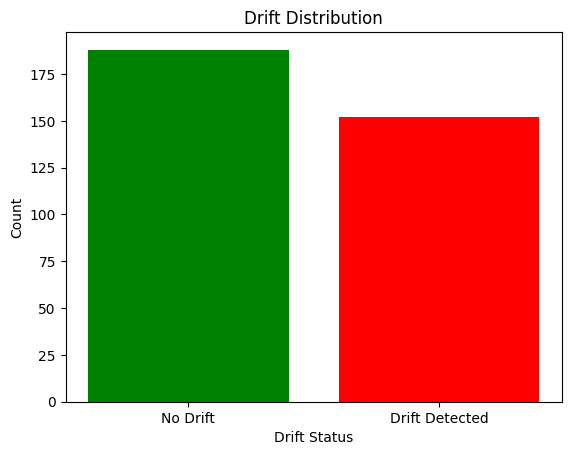

In [13]:
# Import Libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

# Load Dataset
data = pd.read_csv("/content/sample_data/Driftx_Data.csv")  # Replace with the actual path

# Inspect Data
print(data.info())
print(data.head())

# Data Cleaning
# Drop Missing Values
data.dropna(inplace=True)

# Encode Baseline and Runtime Values
label_encoder = LabelEncoder()
data['Baseline_Value'] = label_encoder.fit_transform(data['Baseline_Value'])
data['Runtime_Value'] = label_encoder.fit_transform(data['Runtime_Value'])

# Add Drift Column
data['Drift'] = (data['Baseline_Value'] != data['Runtime_Value']).astype(int)

# Save Processed Data for Reuse
data.to_csv("Processed_AWS_Config_Data.csv", index=False)

# Prepare Features and Target
X = pd.get_dummies(data[['Resource_Type', 'Attribute', 'Baseline_Value', 'Runtime_Value']], columns=['Resource_Type', 'Attribute'])
y = data['Drift']

# Save Feature Names
joblib.dump(X.columns, "feature_names.pkl")

# Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the Trained Model
joblib.dump(model, "drift_detection_model.pkl")

# Evaluate Model
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Show Cleaned Data
print(data.head())

# Graphical Representation: Drift Distribution
import matplotlib.pyplot as plt
drift_counts = data['Drift'].value_counts()
plt.bar(["No Drift", "Drift Detected"], drift_counts, color=["green", "red"])
plt.title("Drift Distribution")
plt.xlabel("Drift Status")
plt.ylabel("Count")
plt.show()


Script to Split Data into Training, Validation, and Testing Sets

In [14]:
from sklearn.model_selection import train_test_split

# Load Processed Data
data = pd.read_csv("Processed_AWS_Config_Data.csv")

# Features and Target
X = data[['Resource_Type', 'Attribute', 'Baseline_Value', 'Runtime_Value']]
y = data['Drift']

# Encode Categorical Features
X = pd.get_dummies(X, columns=['Resource_Type', 'Attribute'])

# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Show Splits
print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")
print(f"Test Set: {X_test.shape}")


Training Set: (238, 46)
Validation Set: (68, 46)
Test Set: (34, 46)


Model Training

Validation Accuracy: 0.8823529411764706
Validation Precision: 0.8108108108108109
Validation Recall: 0.967741935483871


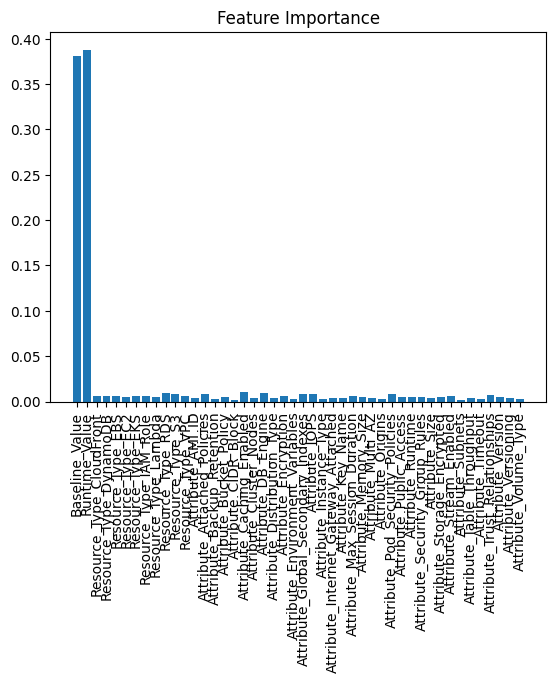

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Train Random Forest Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Validation Performance
y_val_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Precision:", precision_score(y_val, y_val_pred))
print("Validation Recall:", recall_score(y_val, y_val_pred))

# Save Model
import joblib
joblib.dump(model, "drift_detection_model.pkl")

# Graphical Representation: Feature Importance
importances = model.feature_importances_
plt.bar(X_train.columns, importances)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()


Evaluate the Model on the Test Set

Test Accuracy: 0.8529411764705882
Test Precision: 0.7916666666666666
Test Recall: 1.0


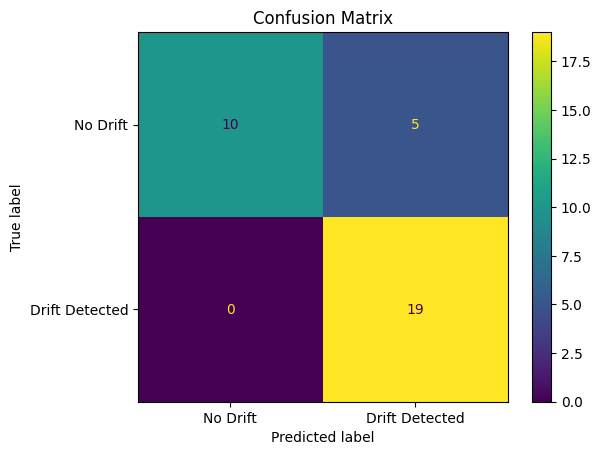

In [16]:
# Load Model
model = joblib.load("drift_detection_model.pkl")

# Test Model
y_test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))

# Graphical Representation: Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=["No Drift", "Drift Detected"])
plt.title("Confusion Matrix")
plt.show()


Predict Drift on New Data

Drift Detected: False


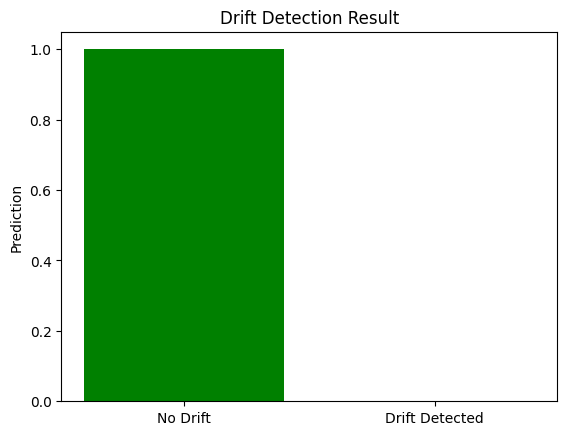

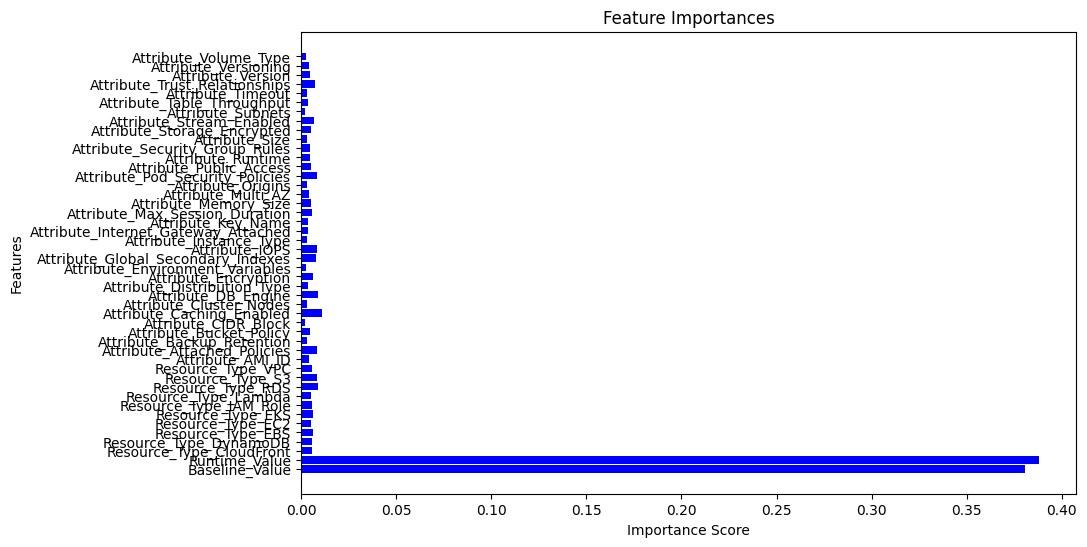

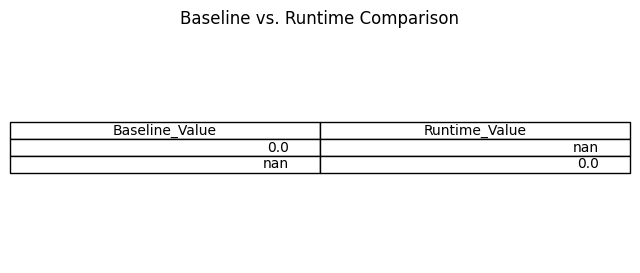

In [19]:
# Import Required Libraries
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load Model and Feature Names
model = joblib.load("drift_detection_model.pkl")
feature_names = joblib.load("feature_names.pkl")

# Simulate New Runtime Data
new_data = pd.DataFrame([
    {"Resource_Type": "EC2", "Attribute": "Instance_Type", "Baseline_Value": "t2.micro", "Runtime_Value": "t2.large"}
])

# Encode Categorical Variables
label_encoder = LabelEncoder()

# Label encoding for 'Baseline_Value' and 'Runtime_Value'
new_data['Baseline_Value'] = label_encoder.fit_transform(new_data['Baseline_Value'])
new_data['Runtime_Value'] = label_encoder.fit_transform(new_data['Runtime_Value'])

# One-Hot Encode 'Resource_Type' and 'Attribute'
new_data = pd.get_dummies(new_data, columns=["Resource_Type", "Attribute"])

# Align Columns with Model Features
for col in feature_names:
    if col not in new_data.columns:
        new_data[col] = 0  # Add missing columns
new_data = new_data[feature_names]  # Ensure column order matches

# Convert to Numeric
new_data = new_data.astype(float)

# Predict Drift
drift_prediction = model.predict(new_data)
is_drift_detected = bool(drift_prediction[0])
print("Drift Detected:", is_drift_detected)

# ---------------------------
# Graphical Representations
# ---------------------------

# 1. Bar Chart: Drift Detection Result
labels = ['No Drift', 'Drift Detected']
values = [1 - is_drift_detected, is_drift_detected]  # 1 for 'No Drift', 0 for 'Drift Detected'

plt.bar(labels, values, color=['green', 'red'])
plt.title('Drift Detection Result')
plt.ylabel('Prediction')
plt.show()

# 2. Feature Importance Visualization
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='blue')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 3. Table Visualization: Baseline vs. Runtime Data
plt.figure(figsize=(8, 3))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
pd.set_option("display.max_columns", None)
table_data = pd.DataFrame(
    {
        "Baseline_Value": new_data.iloc[0].filter(like="Baseline_Value"),
        "Runtime_Value": new_data.iloc[0].filter(like="Runtime_Value"),
    }
)
plt.table(cellText=table_data.values, colLabels=table_data.columns, loc="center")
plt.title("Baseline vs. Runtime Comparison")
plt.show()




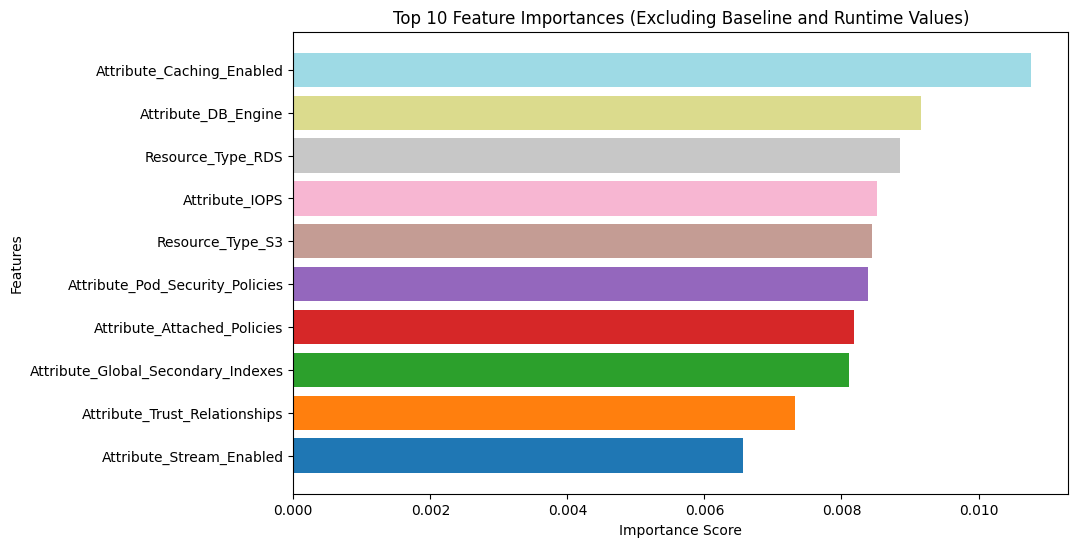

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Set N for top features
top_n = 10

# Exclude Baseline_Value and Runtime_Value from feature names and importance calculations
valid_feature_indices = [
    i for i, feature in enumerate(feature_names)
    if "Baseline_Value" not in feature and "Runtime_Value" not in feature
]
valid_importances = model.feature_importances_[valid_feature_indices]
valid_features = np.array(feature_names)[valid_feature_indices]

# Sort by importance and select top N features
sorted_indices = np.argsort(valid_importances)[-top_n:]  # Indices of top N features

# Generate unique colors for each feature
colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_indices)))

# Plot Top N Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(
    valid_features[sorted_indices],
    valid_importances[sorted_indices],
    color=colors
)
plt.title(f'Top {top_n} Feature Importances (Excluding Baseline and Runtime Values)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()



In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

# Load Dataset
data = pd.read_csv("/content/sample_data/Driftx_Data.csv")  # Replace with the actual path

# Print Dataset Information
print("Dataset Info:")
print(data.info())  # Summary of the dataset
print("\nSample Data:")
print(data.head())  # Display the first 5 rows of the dataset

# Data Preprocessing
data.dropna(inplace=True)  # Drop missing values

# Encode Baseline and Runtime Values
label_encoder = LabelEncoder()
data['Baseline_Value'] = label_encoder.fit_transform(data['Baseline_Value'])
data['Runtime_Value'] = label_encoder.fit_transform(data['Runtime_Value'])

# Add Drift Column
data['Drift'] = (data['Baseline_Value'] != data['Runtime_Value']).astype(int)

# Print Processed Dataset
print("\nProcessed Dataset:")
print(data.head())

# Prepare Features and Target
X = pd.get_dummies(data[['Resource_Type', 'Attribute', 'Baseline_Value', 'Runtime_Value']], columns=['Resource_Type', 'Attribute'])
y = data['Drift']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the Model and Feature Names
joblib.dump(model, "drift_detection_model.pkl")
joblib.dump(X.columns, "feature_names.pkl")

# Evaluate the Model
accuracy = model.score(X_test, y_test)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

# Print Sample Rows After Encoding
print("\nEncoded Dataset Sample:")
print(data[['Resource_Type', 'Resource_ID', 'Attribute', 'Baseline_Value', 'Runtime_Value', 'Drift']].head())

# Summary of Processed Dataset
print("\nSummary of Processed Dataset:")
print(data.describe(include='all'))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Resource_Type   340 non-null    object
 1   Resource_ID     340 non-null    object
 2   Attribute       340 non-null    object
 3   Baseline_Value  340 non-null    object
 4   Runtime_Value   340 non-null    object
dtypes: object(5)
memory usage: 13.4+ KB
None

Sample Data:
  Resource_Type Resource_ID             Attribute         Baseline_Value  \
0           EC2       ec2-1         Instance_Type               t2.large   
1           EC2       ec2-1  Security_Group_Rules  SSH:22-203.0.113.0/24   
2           EC2       ec2-1                AMI_ID           ami-12345678   
3           EC2       ec2-1              Key_Name                  key-2   
4           EC2       ec2-2         Instance_Type               t2.large   

      Runtime_Value  
0          t2.large  
1  SSH:22-0.0

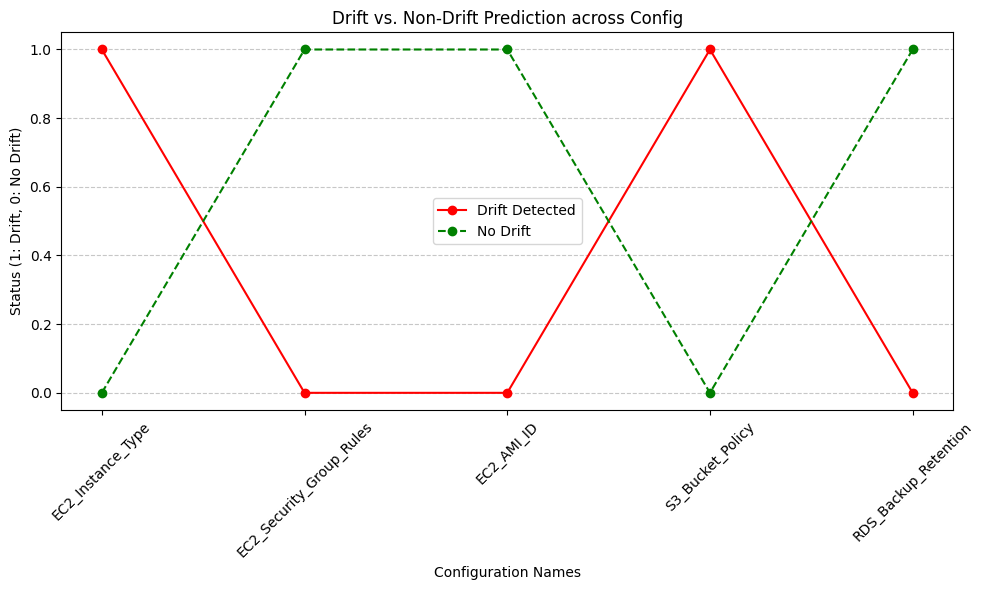

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulated Combined Drift and Non-Drift Data with Realistic Config Names
data = pd.DataFrame([
    {"Config_Name": "EC2_Instance_Type", "Baseline_Value": "t2.micro", "Runtime_Value": "t2.large", "Drift": 1},
    {"Config_Name": "EC2_Security_Group_Rules", "Baseline_Value": "SSH:22-203.0.113.0/24", "Runtime_Value": "SSH:22-203.0.113.0/24", "Drift": 0},
    {"Config_Name": "EC2_AMI_ID", "Baseline_Value": "ami-12345678", "Runtime_Value": "ami-12345678", "Drift": 0},
    {"Config_Name": "S3_Bucket_Policy", "Baseline_Value": "Public", "Runtime_Value": "Private", "Drift": 1},
    {"Config_Name": "RDS_Backup_Retention", "Baseline_Value": "7 days", "Runtime_Value": "7 days", "Drift": 0},
])

# Plot Drift and Non-Drift as Separate Lines on the Same Graph
plt.figure(figsize=(10, 6))

# Plot Drift Detected Line
plt.plot(data['Config_Name'], data['Drift'], marker='o', linestyle='-', color='red', label='Drift Detected')

# Plot Non-Drift Line (Inverse of Drift)
non_drift = 1 - data['Drift']
plt.plot(data['Config_Name'], non_drift, marker='o', linestyle='--', color='green', label='No Drift')

# Add Titles and Labels
plt.title('Drift vs. Non-Drift Prediction across Config')
plt.xlabel('Configuration Names')
plt.ylabel('Status (1: Drift, 0: No Drift)')
plt.xticks(rotation=45)  # Rotate configuration names for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Drift Vs Non Drift Prediction Accuracy

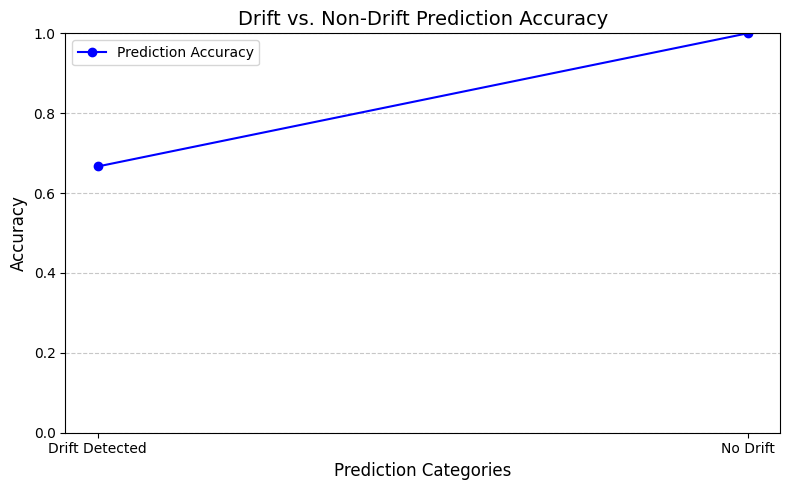

In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Simulated Real Dataset (Modify as needed)
data = pd.DataFrame([
    {"Resource_Type": "EC2", "Attribute": "Instance_Type", "Baseline_Value": "t2.micro", "Runtime_Value": "t2.large", "Drift": 1, "Predicted_Drift": 1},
    {"Resource_Type": "EC2", "Attribute": "Security_Group_Rules", "Baseline_Value": "SSH:22-203.0.113.0/24", "Runtime_Value": "SSH:22-0.0.0.0/0", "Drift": 1, "Predicted_Drift": 0},
    {"Resource_Type": "EC2", "Attribute": "AMI_ID", "Baseline_Value": "ami-12345678", "Runtime_Value": "ami-12345678", "Drift": 0, "Predicted_Drift": 0},
    {"Resource_Type": "S3", "Attribute": "Bucket_Policy", "Baseline_Value": "Public", "Runtime_Value": "Private", "Drift": 1, "Predicted_Drift": 1},
    {"Resource_Type": "RDS", "Attribute": "Backup_Retention", "Baseline_Value": "7 days", "Runtime_Value": "7 days", "Drift": 0, "Predicted_Drift": 0},
])

# Calculate Accuracy for Drift and Non-Drift
actual_drift = data[data['Drift'] == 1]
actual_no_drift = data[data['Drift'] == 0]

drift_accuracy = accuracy_score(actual_drift['Drift'], actual_drift['Predicted_Drift'])
no_drift_accuracy = accuracy_score(actual_no_drift['Drift'], actual_no_drift['Predicted_Drift'])

# Accuracy Data for Line Graph
categories = ['Drift Detected', 'No Drift']
accuracy = [drift_accuracy, no_drift_accuracy]

# Plot Line Graph
plt.figure(figsize=(8, 5))
plt.plot(categories, accuracy, marker='o', linestyle='-', color='blue', label='Prediction Accuracy')
plt.title('Drift vs. Non-Drift Prediction Accuracy', fontsize=14)
plt.xlabel('Prediction Categories', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)  # Set y-axis to range between 0 and 1 for accuracy
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the Plot
plt.show()
